In [ ]:
!pip install speechbrain librosa transformers torchaudio

In [ ]:
# Required imports
import os
import librosa
import numpy as np
import pandas as pd
import kagglehub

# Download RAVDESS dataset from KaggleHub (if not already downloaded)
# This step assumes the dataset is available via KaggleHub.
# If the dataset is already mounted, this line can be commented out or removed.
try:
    path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
    ravdess_dir = path  # Define the dataset directory
    print(f"Dataset downloaded to: {ravdess_dir}")
except Exception as e:
    print(f"Could not download dataset using kagglehub: {e}")
    # Fallback to the previously assumed mounted path if download fails
    ravdess_dir = '/kaggle/input/ravdess-emotional-speech-audio'
    print(f"Attempting to use mounted dataset path: {ravdess_dir}")


# Create a list to store extracted features, labels, and file paths
features_list = []

# Check if directory exists and process audio
if os.path.exists(ravdess_dir):
    print("Dataset directory found. Proceeding with data loading and feature extraction.")
    # Assuming the audio files are within subdirectories like "Actor_01", "Actor_02", etc.
    for actor_folder in os.listdir(ravdess_dir):
        actor_path = os.path.join(ravdess_dir, actor_folder)
        if os.path.isdir(actor_path):
            for audio_file in os.listdir(actor_path):
                audio_path = os.path.join(actor_path, audio_file)
                if audio_file.endswith('.wav'):
                    try:
                        # Load the audio file
                        y, sr = librosa.load(audio_path, sr=None)

                        # Extract relevant audio features
                        # MFCCs (n_mfcc=40 as per previous exploration)
                        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
                        mfccs_mean = np.mean(mfccs.T, axis=0)

                        # Pitch (using pyin for robustness)
                        pitches, magnitudes = librosa.core.piptrack(y=y, sr=sr)
                        # Handle cases where no pitch is detected
                        pitch = np.mean(pitches[magnitudes > 0]) if np.any(magnitudes > 0) else 0

                        # Energy (RMS)
                        energy = np.mean(librosa.feature.rms(y=y))

                        # Chroma STFT
                        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
                        chroma_mean = np.mean(chroma_stft, axis=1)

                        # Spectral Contrast
                        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
                        contrast_mean = np.mean(spectral_contrast, axis=1)

                        # Zero Crossing Rate
                        zcr = librosa.feature.zero_crossing_rate(y=y)
                        zcr_mean = np.mean(zcr)

                        # Tonnetz
                        try:
                            tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
                            tonnetz_mean = np.mean(tonnetz, axis=1)
                        except Exception as tonnetz_e:
                             print(f"Could not compute tonnetz for {audio_file}: {tonnetz_e}")
                             tonnetz_mean = np.zeros(6) # Use zeros if tonnetz computation fails


                        # Determine the emotion label
                        # File naming convention: emotion-intensity-statement-repetition-actor.wav
                        # Emotion codes: 01=neutral, 02=calm, 03=happy, 04=sad, 05=angry, 06=fearful, 07=disgust, 08=surprised
                        label = int(audio_file.split('-')[2])

                        # Combine all features into a single vector
                        features_vector = np.concatenate([
                            mfccs_mean,
                            chroma_mean,
                            contrast_mean,
                            [zcr_mean], # ZCR is a single value, make it a list for concatenation
                            tonnetz_mean
                        ]).tolist() # Convert to list for storage in DataFrame

                        # Store the extracted features and the corresponding emotion label
                        features_list.append({
                            'features': features_vector,
                            'label': label,
                            'path': audio_path # Store the audio file path
                        })

                    except Exception as e:
                        print(f"Error processing {audio_file}: {e}")
else:
    print(f"\nDataset directory not found at: {ravdess_dir}")
    print("Please ensure the dataset is correctly mounted.")


# 5. Organize the collected features and labels into a structured format
if features_list:
    df_features = pd.DataFrame(features_list)

    # Expand the features list into separate columns
    features_df_expanded = pd.DataFrame(df_features['features'].tolist(), index=df_features.index)

    # Concatenate the expanded features with the label and path
    df_processed = pd.concat([features_df_expanded, df_features[['label', 'path']]], axis=1)

    # Rename the feature columns for clarity
    feature_column_names = [f'feature_{i}' for i in range(features_df_expanded.shape[1])]
    df_processed.columns = feature_column_names + ['label', 'path']


    display(df_processed.head())
    print("\nShape of processed dataframe:", df_processed.shape)

else:
    print("No features were extracted. Please check the dataset path and structure after mounting.")

Dataset directory found. Proceeding with data loading and feature extraction.


mfcc_0     mfcc_1     mfcc_2    mfcc_3    mfcc_4    mfcc_5     mfcc_6  \
0 -601.557068  56.227070 -14.788618  5.832396 -0.544787  1.759662 -13.963181   
1 -675.851807  68.959435  -4.962603  5.423141  0.609842  3.160732  -9.528844   
2 -604.800964  67.389900 -13.988151  8.438960 -4.720516 -2.079224  -7.776217   
3 -676.821228  79.525734 -12.700563  8.421185 -1.814425 -0.365204  -5.796458   
4 -640.296814  64.622581  -5.608733  3.477045 -2.100553  2.704671  -9.134014   

     mfcc_7     mfcc_8    mfcc_9   mfcc_10   mfcc_11   mfcc_12        pitch  \
0  3.950095  -7.412675 -1.880631 -2.538129 -3.536913 -2.970739  1779.137085   
1  2.647469  -9.230493 -3.492379 -2.775557 -0.858337 -3.252905  1710.909912   
2  2.852065 -10.106051 -6.681345 -3.561178  0.107069 -4.102225  1830.700562   
3  1.607946 -12.252427 -7.244750 -3.781543 -0.115951 -3.911265  1806.420898   
4  2.263086  -9.458851 -4.599762 -3.946795 -1.724058 -3.941357  1737.885742   

     energy  label                                               path  
0  0.006677      8  /kaggle/input/ravdess-emotional-speech-audio/A...  
1  0.003345      1  /kaggle/input/ravdess-emotional-speech-audio/A...  
2  0.005705      7  /kaggle/input/ravdess-emotional-speech-audio/A...  
3  0.002855      7  /kaggle/input/ravdess-emotional-speech-audio/A...  
4  0.005130      1  /kaggle/input/ravdess-emotional-speech-audio/A...

In [ ]:
# now lers define the plotting and audio functions
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio, display

def waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(data, sr=sr)
    plt.title(f'Waveform - {emotion}')
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

def spectrogram(data, sr, emotion):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(10, 3))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.title(f'Spectrogram - {emotion}')
    plt.show()


 Emotion : SURPRISED


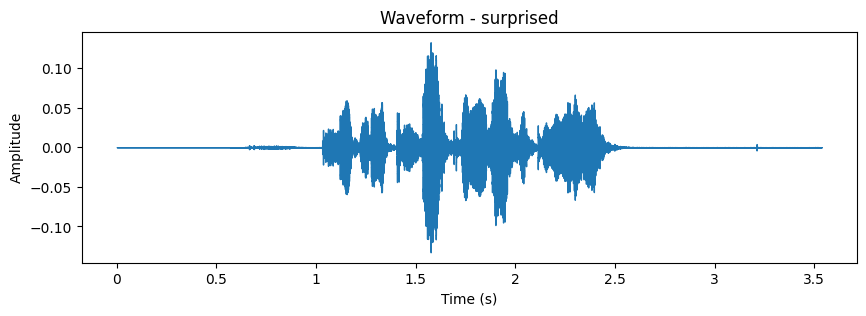

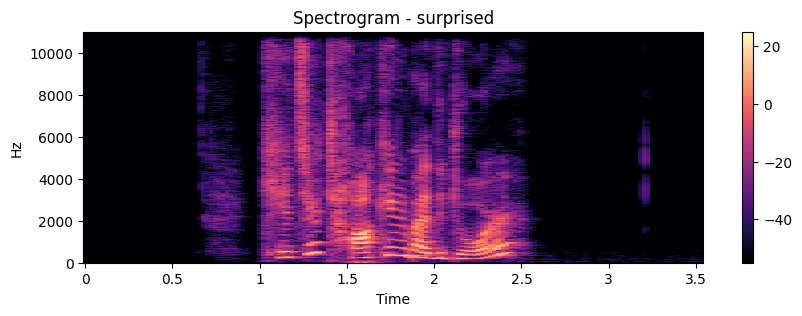


 Emotion : NEUTRAL


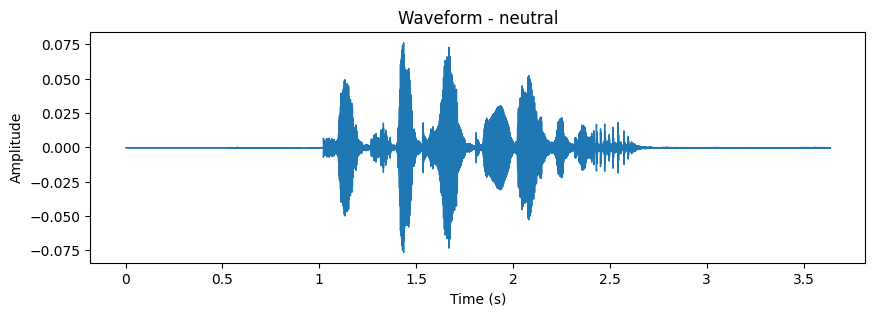

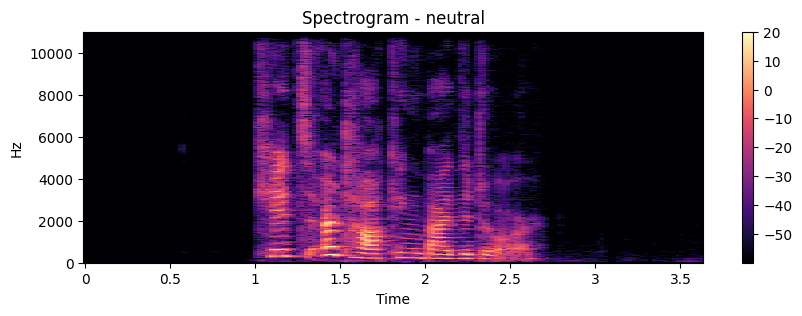


 Emotion : DISGUST


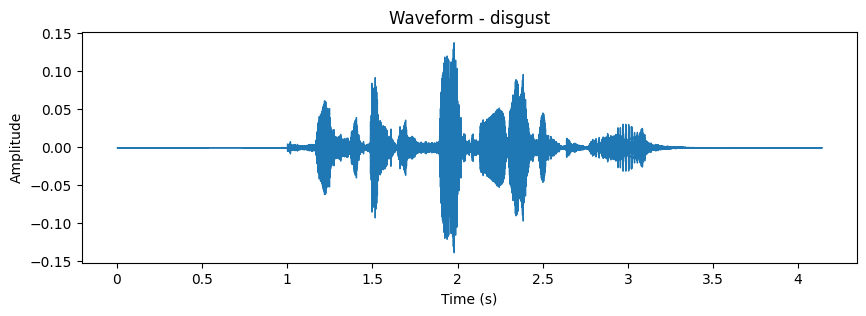

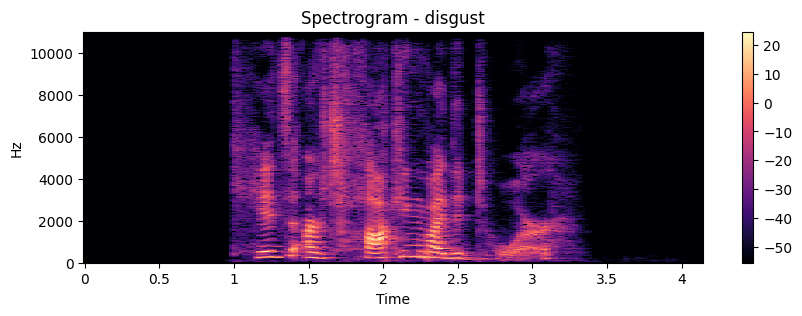


 Emotion : FEARFUL


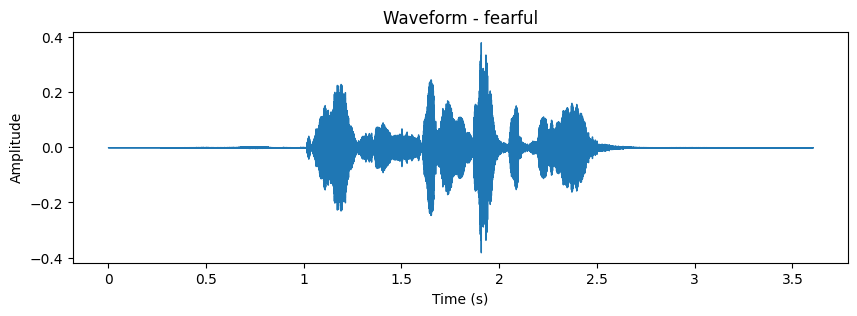

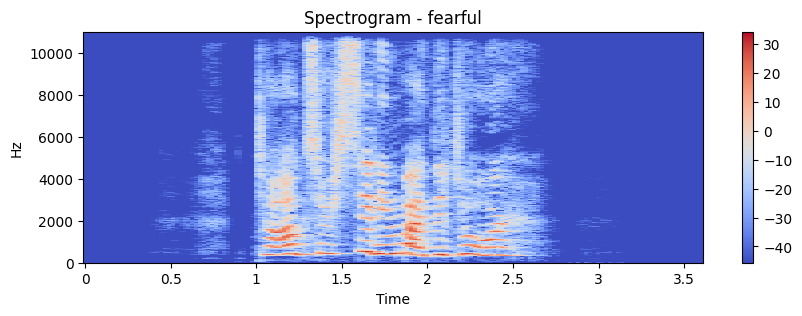


 Emotion : SAD


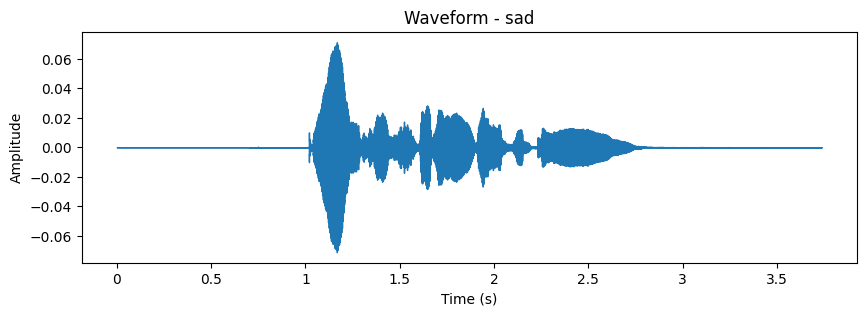

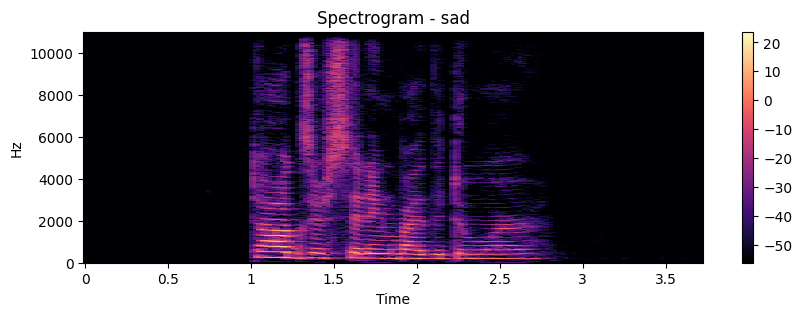


 Emotion : CALM


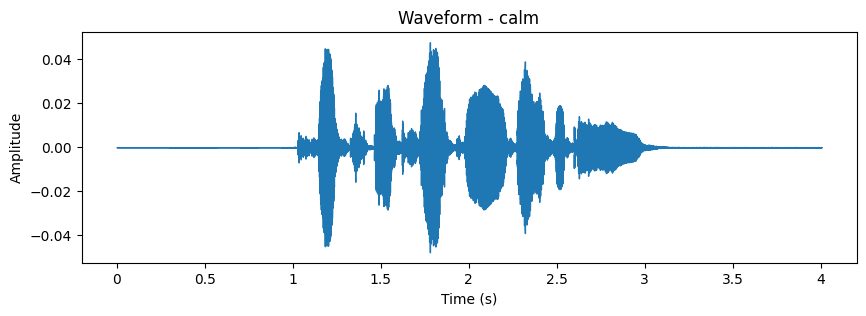

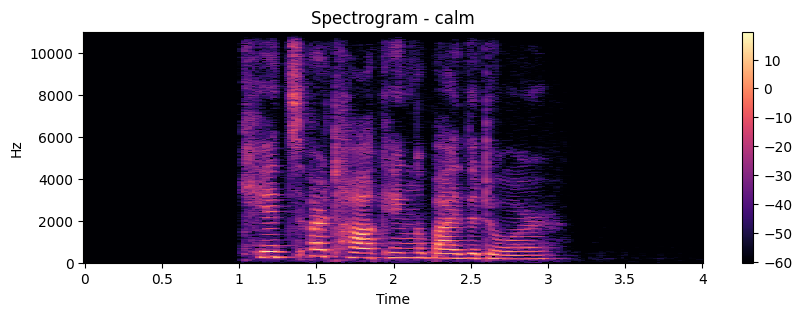


 Emotion : HAPPY


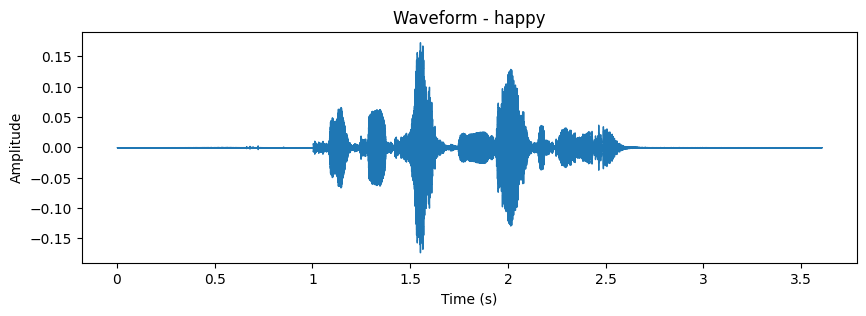

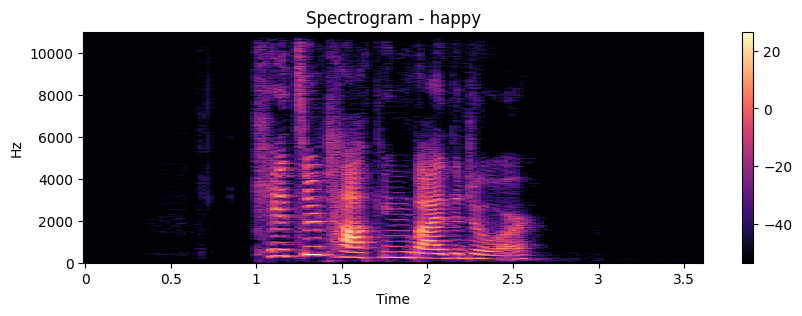


 Emotion : ANGRY


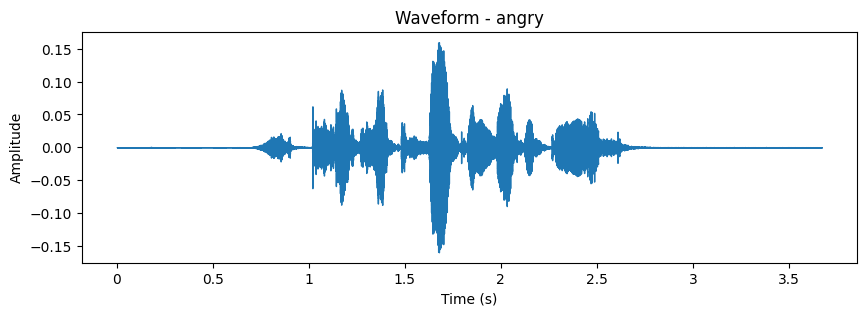

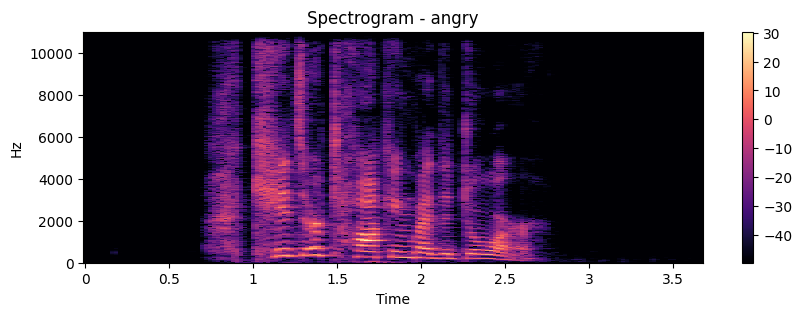

In [ ]:
# Define a dictionary to map numerical labels to emotion names
emotion_dict = {
    1: 'neutral',
    2: 'calm',
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fearful',
    7: 'disgust',
    8: 'surprised'
}

for label_code in df_processed['label'].unique():
    # Get the emotion name from the dictionary
    emotion = emotion_dict.get(label_code, 'unknown')
    print(f'\n Emotion : {emotion.upper()}')

    # Get the path of a sample audio file for the current emotion
    # Ensure we are getting the file path, not the DataFrame index
    sample_path = df_processed[df_processed['label'] == label_code]['path'].iloc[0]

    y, sr = librosa.load(sample_path)

    waveplot(y, sr, emotion)
    spectrogram(y, sr, emotion)
    display(Audio(sample_path))

Checking for null values

In [ ]:
print("Null values in each column :")
print(df_processed.isnull().sum())

Null values in each column :
mfcc_0     0
mfcc_1     0
mfcc_2     0
mfcc_3     0
mfcc_4     0
mfcc_5     0
mfcc_6     0
mfcc_7     0
mfcc_8     0
mfcc_9     0
mfcc_10    0
mfcc_11    0
mfcc_12    0
pitch      0
energy     0
label      0
path       0
dtype: int64


In [ ]:
print("\n Original shape of the dataset :",df_processed.shape)


 Original shape of the dataset : (1440, 17)


In [ ]:
# Remove rows where pitch is 0
df_cleaned = df_processed[df_processed['pitch'] > 0].copy()

# Reset index
df_cleaned.reset_index(drop=True, inplace=True)

# Print the shape of the full DataFrame
print("Shape after removing zero-pitch rows:", df_cleaned.shape)


Shape after removing zero-pitch rows: (1440, 17)


In [ ]:
print("Unique audio paths:", df_cleaned['path'].nunique())


Unique audio paths: 1440


In [ ]:
df_cleaned.head(10)


mfcc_0     mfcc_1     mfcc_2    mfcc_3     mfcc_4    mfcc_5     mfcc_6  \
0 -601.557068  56.227070 -14.788618  5.832396  -0.544787  1.759662 -13.963181   
1 -675.851807  68.959435  -4.962603  5.423141   0.609842  3.160732  -9.528844   
2 -604.800964  67.389900 -13.988151  8.438960  -4.720516 -2.079224  -7.776217   
3 -676.821228  79.525734 -12.700563  8.421185  -1.814425 -0.365204  -5.796458   
4 -640.296814  64.622581  -5.608733  3.477045  -2.100553  2.704671  -9.134014   
5 -515.998291  38.055786 -27.663736 -3.225222 -11.483253 -1.980056 -17.871075   
6 -683.294250  59.915516  -0.359815  6.508976  -1.467618  2.875048  -8.309567   
7 -677.497253  66.737923  -7.066271  6.711427   2.317029  2.578446  -9.735838   
8 -685.270142  66.034645  -5.312263  8.085226  -0.225384  3.311465  -9.604638   
9 -615.369812  64.712395 -17.525738  1.072118   2.143257 -0.745155 -10.137992   

     mfcc_7     mfcc_8    mfcc_9   mfcc_10   mfcc_11    mfcc_12        pitch  \
0  3.950095  -7.412675 -1.880631 -2.538129 -3.536913  -2.970739  1779.137085   
1  2.647469  -9.230493 -3.492379 -2.775557 -0.858337  -3.252905  1710.909912   
2  2.852065 -10.106051 -6.681345 -3.561178  0.107069  -4.102225  1830.700562   
3  1.607946 -12.252427 -7.244750 -3.781543 -0.115951  -3.911265  1806.420898   
4  2.263086  -9.458851 -4.599762 -3.946795 -1.724058  -3.941357  1737.885742   
5 -2.427586 -12.107833 -9.330832 -5.251732 -4.981838 -10.160073  1995.687256   
6 -0.596347 -11.488852 -5.763159 -3.149896 -3.248487  -5.245757  1832.146973   
7  3.739982  -9.666592 -1.574834 -2.758455 -1.905533  -2.608649  1785.711670   
8  4.020546 -10.162641 -3.711770 -2.503744 -3.869077  -2.986640  1852.656372   
9  1.439839  -9.424702 -8.146935 -1.778335 -3.564710  -4.969930  1907.341553   

     energy  label                                               path  
0  0.006677      8  /kaggle/input/ravdess-emotional-speech-audio/A...  
1  0.003345      1  /kaggle/input/ravdess-emotional-speech-audio/A...  
2  0.005705      7  /kaggle/input/ravdess-emotional-speech-audio/A...  
3  0.002855      7  /kaggle/input/ravdess-emotional-speech-audio/A...  
4  0.005130      1  /kaggle/input/ravdess-emotional-speech-audio/A...  
5  0.017979      6  /kaggle/input/ravdess-emotional-speech-audio/A...  
6  0.003168      4  /kaggle/input/ravdess-emotional-speech-audio/A...  
7  0.003326      1  /kaggle/input/ravdess-emotional-speech-audio/A...  
8  0.003189      2  /kaggle/input/ravdess-emotional-speech-audio/A...  
9  0.006350      3  /kaggle/input/ravdess-emotional-speech-audio/A...

In [ ]:
df_cleaned = df_cleaned.drop_duplicates().reset_index(drop=True)
print("Shape after removing duplicates:", df_cleaned.shape)


Shape after removing duplicates: (1440, 17)


checking for abnormal MFCC values (Nans, inf, outliers)

In [ ]:
# Check if any MFCC columns have NaNs or inf
mfcc_cols = [col for col in df_cleaned.columns if col.startswith('mfcc_')]
invalid_mfcc_rows = df_cleaned[mfcc_cols].isnull().any(axis=1) | df_cleaned[mfcc_cols].isin([np.inf, -np.inf]).any(axis=1)

print(f"Number of rows with invalid MFCC values: {invalid_mfcc_rows.sum()}")

# Drop rows with invalid MFCCs
df_cleaned = df_cleaned[~invalid_mfcc_rows].reset_index(drop=True)
print("Shape after removing rows with invalid MFCCs:", df_cleaned.shape)


Number of rows with invalid MFCC values: 0
Shape after removing rows with invalid MFCCs: (1440, 17)


In [ ]:
print("Cleaned dataset summary:")
print(df_cleaned.describe())
print("\nFinal shape of cleaned dataset:", df_cleaned.shape)


Cleaned dataset summary:
            mfcc_0       mfcc_1       mfcc_2       mfcc_3       mfcc_4  \
count  1440.000000  1440.000000  1440.000000  1440.000000  1440.000000   
mean   -617.135425    66.092420    -4.855443    10.203428    -0.221090   
std     102.579621    14.824665    11.792966     8.137515     6.869429   
min    -873.242310    18.962200   -51.957912   -17.508692   -22.980276   
25%    -693.664764    55.786286   -12.181196     4.912715    -4.880035   
50%    -622.848907    66.310314    -4.090637    10.303168    -0.376970   
75%    -551.604279    76.615627     3.577858    15.061990     4.965186   
max    -333.377960   115.125786    22.603916    36.563427    21.130016   

            mfcc_5       mfcc_6       mfcc_7       mfcc_8       mfcc_9  \
count  1440.000000  1440.000000  1440.000000  1440.000000  1440.000000   
mean      8.248786    -8.382126     0.882888    -7.187926    -5.599998   
std       7.182301     6.067137     5.215737     4.970867     4.349589   
min     -11.

##EDA

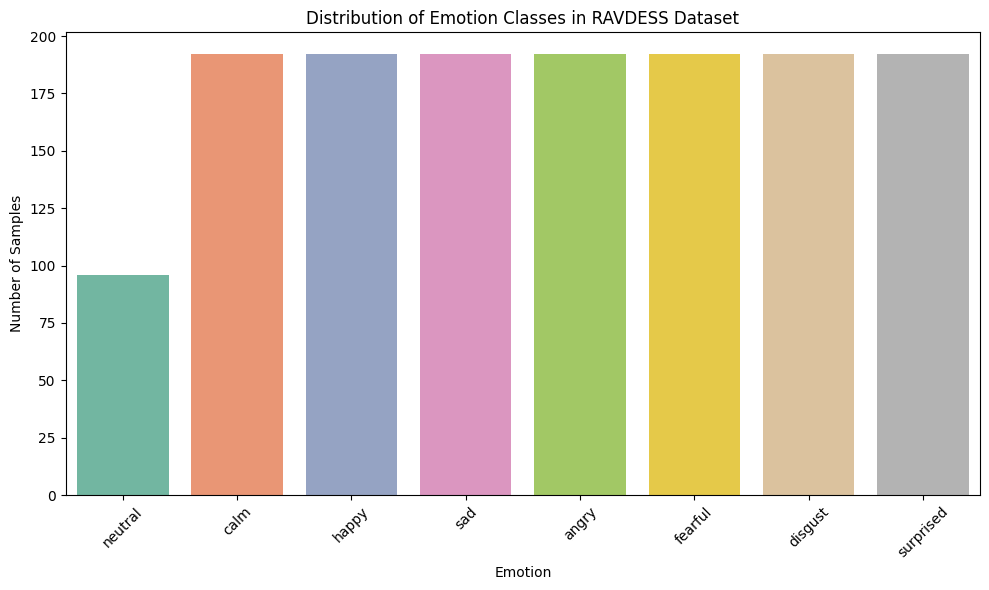

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Countplot for emotion labels
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df_cleaned, palette='Set2')

# Add emotion names on x-axis
emotion_names = {
    1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
    5: 'angry', 6: 'fearful', 7: 'disgust', 8: 'surprised'
}
plt.xticks(ticks=range(8), labels=[emotion_names[i+1] for i in range(8)], rotation=45)
plt.title('Distribution of Emotion Classes in RAVDESS Dataset')
plt.xlabel('Emotion')
plt.ylabel('Number of Samples')
plt.tight_layout()
plt.show()


#Pitch nad energy distribution per emotion

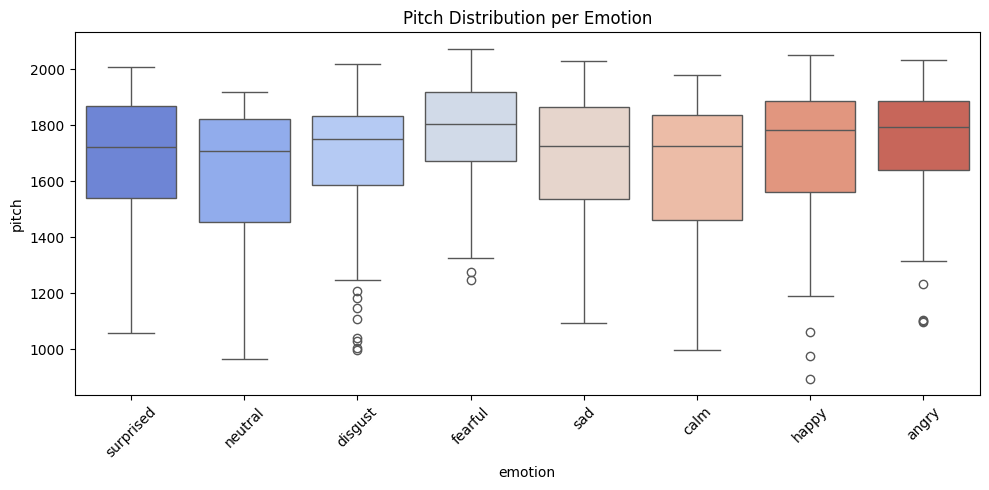

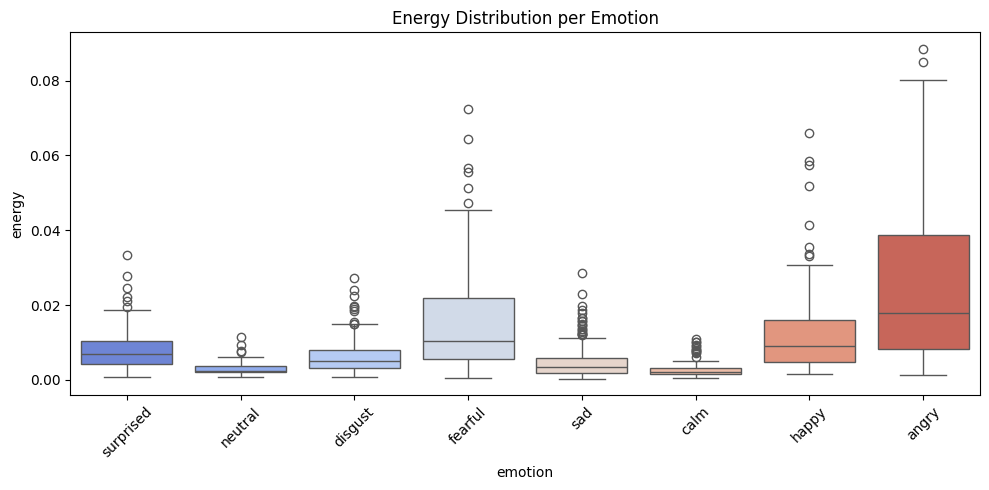

In [ ]:
# Add emotion name column for grouping
df_cleaned['emotion'] = df_cleaned['label'].map(emotion_names)

# Pitch distribution
plt.figure(figsize=(10, 5))
sns.boxplot(x='emotion', y='pitch', data=df_cleaned, palette='coolwarm')
plt.title('Pitch Distribution per Emotion')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Energy distribution
plt.figure(figsize=(10, 5))
sns.boxplot(x='emotion', y='energy', data=df_cleaned, palette='coolwarm')
plt.title('Energy Distribution per Emotion')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# correlation between features

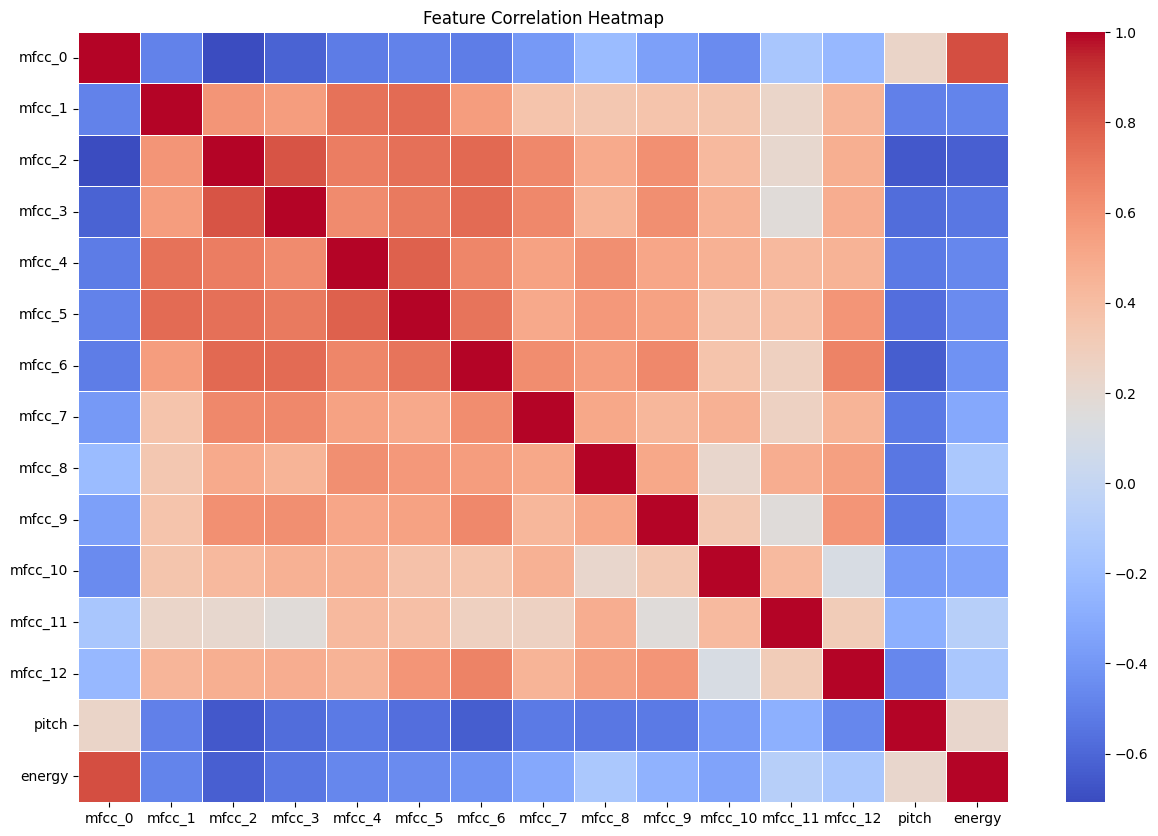

In [ ]:
# Drop non-numeric columns
numeric_df = df_cleaned.drop(['label', 'path', 'emotion'], axis=1)

# Compute correlation matrix
corr = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()


## Feature Engineering andOptimization

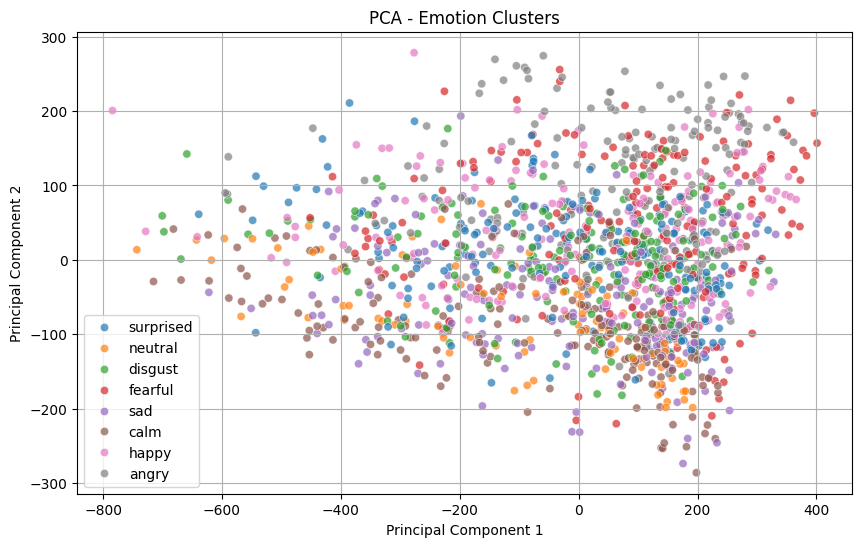

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Select features
feature_cols = [col for col in df_cleaned.columns if col.startswith('mfcc_')] + ['pitch', 'energy']
X = df_cleaned[feature_cols]
y = df_cleaned['label']

# Reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create DataFrame for plotting
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['label'] = y.map(emotion_dict)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='label', palette='tab10', alpha=0.7)
plt.title('PCA - Emotion Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [ ]:
# Expanding mfccs , more mfccs capture finer cariations in speech tome and timbre
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
mfcc_mean = np.mean(mfccs.T, axis=0)





In [ ]:
chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
zcr = librosa.feature.zero_crossing_rate(y=y)
tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)


#aggregate mean or standard deviation across time axis


In [ ]:
chroma_mean = np.mean(chroma_stft, axis=1)
contrast_mean = np.mean(spectral_contrast, axis=1)
zcr_mean = np.mean(zcr)
tonnetz_mean = np.mean(tonnetz, axis=1)


In [ ]:
## final feature vector
features = np.concatenate([mfcc_mean, chroma_mean, contrast_mean, [zcr_mean], tonnetz_mean])


# Feature Scaling
standardScaler for zero mean & unit variance.



In [ ]:
from sklearn.preprocessing import StandardScaler

# Drop label and path columns to keep only features
X_features = df_processed.drop(['label', 'path'], axis=1)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)
y = df_processed['label']  # If you're preparing for ML later


 t-SNE:
Nonlinear dimensionality reduction, great for emotional cluster visualization.



In [ ]:
from sklearn.manifold import TSNE
X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_scaled)


In [ ]:
# label enci=oding the y values

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = df_processed['label']  # assuming 'label' column contains emotion codes like 1–8
y_encoded = le.fit_transform(y)


In [ ]:
#mappin emotions
emotion_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(emotion_mapping)  # e.g., {1: 0, 2: 1, ..., 8: 7}


{np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(6): np.int64(5), np.int64(7): np.int64(6), np.int64(8): np.int64(7)}


In [ ]:
### split the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


##Modelling

for modelling lets use the traditoinal ml baseline models like linear regression random forrest and svm and for deeplearning lets use  LSTM and Wav2Vec2

Logistic REgression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression:\n", classification_report(y_test, y_pred_lr))


Logistic Regression:
               precision    recall  f1-score   support

           1       0.20      0.11      0.14        19
           2       0.40      0.50      0.44        40
           3       0.43      0.39      0.41        41
           4       0.30      0.37      0.33        35
           5       0.55      0.71      0.62        34
           6       0.38      0.42      0.40        31
           7       0.46      0.38      0.41        45
           8       0.39      0.30      0.34        43

    accuracy                           0.41       288
   macro avg       0.39      0.40      0.39       288
weighted avg       0.40      0.41      0.40       288



RAndom Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest:\n", classification_report(y_test, y_pred_rf))


Random Forest:
               precision    recall  f1-score   support

           1       0.58      0.37      0.45        19
           2       0.52      0.82      0.63        40
           3       0.70      0.51      0.59        41
           4       0.50      0.54      0.52        35
           5       0.66      0.74      0.69        34
           6       0.49      0.61      0.54        31
           7       0.63      0.38      0.47        45
           8       0.57      0.53      0.55        43

    accuracy                           0.57       288
   macro avg       0.58      0.56      0.56       288
weighted avg       0.58      0.57      0.56       288



SVM

In [ ]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("SVM:\n", classification_report(y_test, y_pred_svm))


SVM:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        19
           2       0.27      0.35      0.30        40
           3       0.00      0.00      0.00        41
           4       0.17      0.54      0.26        35
           5       0.46      0.50      0.48        34
           6       0.11      0.26      0.16        31
           7       0.00      0.00      0.00        45
           8       0.33      0.05      0.08        43

    accuracy                           0.21       288
   macro avg       0.17      0.21      0.16       288
weighted avg       0.17      0.21      0.16       288



The above 3 act as a baseline to compare against deeper models


Deep Learning(LSTM)

In [ ]:
import torch
import torch.nn as nn

class EmotionLSTM(nn.Module):
    def __init__(self, input_size=40, hidden_size=128, num_layers=2, num_classes=8, dropout=0.3):
        super(EmotionLSTM, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        out, (hn, cn) = self.lstm(x)  # Take output from last time step
        out = out[:, -1, :]  # (batch_size, hidden_size)
        out = self.fc(out)
        return out


In [ ]:
model = EmotionLSTM(input_size=40, num_classes=8)  # assuming 40 MFCCs and 8 emotion classes
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [12]:
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torch
import torchaudio

# Load pretrained Wav2Vec2 processor and model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
base_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

In [13]:
import torch.nn as nn

class Wav2Vec2EmotionClassifier(nn.Module):
    def __init__(self, base_model, hidden_size=768, num_classes=8):
        super(Wav2Vec2EmotionClassifier, self).__init__()
        self.wav2vec = base_model
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_values, attention_mask=None):
        outputs = self.wav2vec(input_values=input_values, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # (batch_size, seq_len, hidden_size)
        cls_token = hidden_states[:, 0, :]         # Use [CLS]-like token
        logits = self.classifier(cls_token)
        return logits


In [14]:
## preprocessing raw files with no mfccs
def preprocess_audio(file_path):
    waveform, sr = torchaudio.load(file_path)
    waveform = waveform.squeeze()

    # Resample if needed
    if sr != 16000:
        waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)(waveform)

    # Tokenize
    inputs = processor(waveform, sampling_rate=16000, return_tensors="pt", padding=True)
    return inputs


In [15]:
def predict_emotion(file_path):
    inputs = preprocess_audio(file_path)
    input_values = inputs["input_values"].to(device)

    with torch.no_grad():
        logits = base_model(input_values=input_values)
        predicted_class = torch.argmax(logits, dim=-1).item()

    return predicted_class


In [16]:
# Define number of classes based on your dataset (RAVDESS = 8 emotions)
model = Wav2Vec2EmotionClassifier(base_model, num_classes=8)

# Load pretrained classifier weights if available
# model.load_state_dict(torch.load("your_model_path.pth"))

# Set model to eval mode and use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device).eval()


In [17]:
def predict_emotion(file_path):
    inputs = preprocess_audio(file_path)
    input_values = inputs["input_values"].to(device)

    with torch.no_grad():
        logits = model(input_values=input_values)
        predicted_class = torch.argmax(logits, dim=-1).item()

    return predicted_class


In [18]:
# Emotion labels for RAVDESS
emotion_map = {
    1: "Neutral", 2: "Calm", 3: "Happy", 4: "Sad",
    5: "Angry", 6: "Fearful", 7: "Disgust", 8: "Surprised"
}

def print_prediction(file_path):
    pred = predict_emotion(file_path)
    # If your model is trained with 0-based indexing, add +1 to match RAVDESS labels
    emotion = emotion_map.get(pred + 1, "Unknown")
    print(f"🎧 File: {os.path.basename(file_path)} → Emotion: {emotion}")


In [ ]:
# Example usage
test_files = [
    "/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-03-01-01-01-01.wav",
    "/kaggle/input/ravdess-emotional-speech-audio/Actor_03/03-01-04-02-01-01-03.wav"
]

for path in test_files:
    print_prediction(path)
